# **Final Project**

For our final project we try to forecast stock price on a given day from a sequence from previous days data.

We will try several models, starting from a simple LSTM adapted from our Lab 2 work.  With some modifications:

* Removing the last linear layer activation function as we are going to do a forecast and not a classification.

* Reshaping the output dimensions so that we can predict as many features as we like.

* Changing the loss function into a MSE lost.


In [2]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.modules import activation
import torch
from torch import nn
import torch.optim as optim

In [3]:
drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/Mixed_ETF/'

Mounted at /content/drive


In [4]:
file_path = os.path.join(myDrive,'ETF_Data.csv')
data = pd.read_csv(file_path, sep=",", header=0)

Split Data

In [5]:
data.head()

,Date_vaw,Open_vaw,High_vaw,Low_vaw,Close_vaw,Volume_vaw,Open_vcr,High_vcr,Low_vcr,Close_vcr,...,Open_vht,High_vht,Low_vht,Close_vht,Volume_vht,Open_vnq,High_vnq,Low_vnq,Close_vnq,Volume_vnq
0,2005-02-25,54.737,55.614,54.737,55.594,20156,49.021,49.292,49.021,49.255,...,46.707,47.021,46.602,47.021,122102,39.719,40.308,39.719,40.272,39871
1,2005-02-28,55.728,55.728,54.855,55.194,47699,49.274,49.274,49.021,49.183,...,46.800,46.800,46.207,46.476,13375,40.301,40.401,39.749,40.156,72024
2,2005-03-01,55.418,55.640,55.041,55.130,17578,49.403,49.653,49.403,49.653,...,46.622,46.791,46.622,46.753,46598,40.079,40.577,40.079,40.577,45622
3,2005-03-02,54.649,55.263,54.649,55.085,11532,49.589,49.969,49.589,49.784,...,46.587,47.049,46.587,46.791,160287,40.308,40.499,40.207,40.308,20521
4,2005-03-03,55.409,55.409,54.855,55.122,28440,49.822,49.822,49.543,49.755,...,46.883,46.910,46.641,46.724,29446,40.308,40.569,40.224,40.522,12941


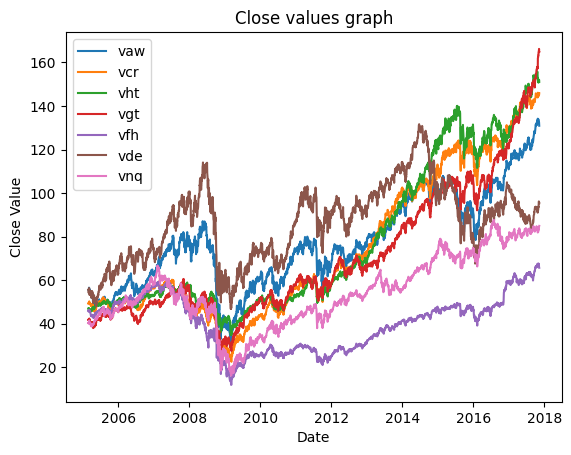

In [6]:
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vaw'], label='vaw')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vcr'], label='vcr')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vht'], label='vht')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vgt'], label='vgt')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vfh'], label='vfh')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vde'], label='vde')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vnq'], label='vnq')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Close values graph')
plt.legend()
plt.show()

In [7]:
data.rename(columns={'Date_vaw': 'Date'}, inplace=True)
data.index = data['Date']
data.pop('Date')
Train = data[:2240]
Validation = data[2240:2560]
Test = data[2560:]
print(Train.shape)
print(Test.shape)
print(len(Test))

(2240, 35)
(320, 35)
(641, 35)
641


In [206]:
import numpy as np

# Compute mean and std across samples and time steps for each feature
mean = np.mean(Train, axis=(0))
std = np.std(Train, axis=(0))
std[std == 0] = 1  # Prevent division by zero

# Normalize training data
#Train_normalized = Train
Train_normalized = (Train - mean) / std

# Normalize training data
#Train_normalized = Train
Train_normalized = (Train - mean) / std

# Normalize test data
# Assuming you have test data: X_test, Y_test
Test_normalized = (Test - mean) / std
#Test_normalized = Test

In [207]:
mode_list = ['multi', 'single']
mode_param = ['multi', 'single']
ETF = ['vaw', 'vcr', 'vgt', 'vfh', 'vde', ' vht', 'vnq']

In [208]:
mode = 'multi'
param = 'single'
ETF_active = ETF[3];
fragment_size = 10;
step = 1
if (param == mode_param[0]):
  if (mode == mode_list[0]):
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

    Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size] for i in range(0, len(Test_normalized ) - fragment_size, 1)]
    Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), 1)]
  else:
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

    Test_Fragmented = [Test_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, 1)]
    Test_Labels = [Test_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), 1)]
else:
  if (mode == mode_list[0]):
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

    Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Test_normalized ) - fragment_size, 1)]
    Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), 1)]
  else:
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Close_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

    Test_Fragmented = [Test_normalized.iloc[i:i + fragment_size][['Close_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, 1)]
    Test_Labels = [Test_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), 1)]


In [209]:
# Print dimensions for verification
print(f'Number of Train Fragments: {len(Train_Fragmented)}')
print(f'Number of Train Labels: {len(Train_Labels)}')
print(f'Number of Test Fragments: {len(Test_Fragmented)}')
print(f'Number of Test Labels: {len(Test_Labels)}')


Number of Train Fragments: 2550
Number of Train Labels: 2550
Number of Test Fragments: 631
Number of Test Labels: 631


In [212]:
tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Fragmented]
X_train = torch.stack(tensor_list)
label_tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Labels]
Y_train =  torch.stack(label_tensor_list)

tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Fragmented]
X_test = torch.stack(tensor_list_test)
label_tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Labels]
Y_test =  torch.stack(label_tensor_list_test)

In [210]:
import torch.nn as nn

class Simple_LSTM(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 output_size: int = 1,
                 num_layers: int = 5,
                 dropout_prob: float = 0.05,
                 activation_function=nn.Softmax(dim=1)):
        # Define RNN or LSTM architecture
        super().__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)

        self.activation_function = activation_function

        self.dropout = nn.Dropout(p=dropout_prob)
        self.batchnorm = nn.BatchNorm1d(hidden_size)

        self.last_linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        _, last_states = self.rnn(X)
        # Get last hidden state for last layer. Ignore cell state in case of LSTMs
        last_hidden_state = last_states[0][-1, :, :]
        # Applying dropout and batch normalization
        #last_hidden_state = self.batchnorm(last_hidden_state)
        #last_hidden_state = self.dropout(last_hidden_state)
        # Get sequence label probability using the last hidden state
        next_prediction = self.last_linear(last_hidden_state)
        return next_prediction


In [211]:
def train_simple_LSTM(X_train, Y_train, model, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
      optimizer.zero_grad()
      output = model(X_train)
      loss = loss_func(output,Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_its)

In [234]:
import matplotlib.pyplot as plt

# Example arrays for Y_predicted and Y
# Ensure these are defined as per your actual data
# Y_predicted = np.random.randn(640, 6)  # Example: If Y_predicted is a 2D array
# Y = np.random.randn(640, 6, 1)  # Example: If Y is a 3D array

def plot_results(Y_squeezed, Y_predicted, title = 'Test sample forecast of vaw', random_color = False):
    # Check the shapes (for debugging purposes)
    print("Y_predicted shape:", Y_predicted.shape)
    print("Y shape after squeezing:", Y_squeezed.shape)

    # Plot the actual signals
    plt.figure(figsize=(12, 8))
    if Y_squeezed.ndim == 2:
      for i in range(Y_squeezed.shape[1]):#for i in range(1):
        if(random_color):
          plt.plot(Y_squeezed[:, i], label=f"Actual Signal {i+1}")
        else:
          plt.plot(Y_squeezed[:, i], label=f"Actual Signal {i+1}", color=f'C{i}')
    else:
      plt.plot(Y_squeezed[:], label=f"Actual Signal {1}")

    # Ensure Y_predicted is compatible for plotting
    if Y_predicted.shape[1] == 1:
        # If Y_predicted is 1D, we plot it directly
        plt.plot(Y_predicted, label="Predicted Signal", linestyle='--')
    elif Y_predicted.ndim == 2 and Y_predicted.shape[1] == Y_squeezed.shape[1]:
        # If Y_predicted is 2D, plot each predicted signal
        for i in range(Y_predicted.shape[1]):#for i in range(1):
          if(random_color):
            plt.plot(Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}")
          else:
            plt.plot(Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}", color=f'C{i}')

    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [214]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming X_train, Y_train, X_test, Y_test are already defined and normalized
X_train_pt = X_train.float().to(device)
Y_train_pt = Y_train.float().to(device)
X_test_pt = X_test.float().to(device)
Y_test_pt = Y_test.float().to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_pt, Y_train_pt)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

print(X_train.shape)
print(Y_train.shape)

torch.Size([2550, 10, 7])
torch.Size([2550, 7])


In [226]:
if (param == mode_param[0]):
  if (mode == mode_list[0]):
    input_size = 35
    hidden_size = 2048
    num_layers = 1
    output_size = 7
    num_epochs = 50
  else:
    input_size = 5
    hidden_size = 256 #32
    num_layers = 1
    output_size = 1
    num_epochs = 20
else:
  if (mode == mode_list[0]):
    input_size = 7
    hidden_size = 256
    num_layers = 1
    output_size = 7
    num_epochs = 80
  else:
    input_size = 1
    hidden_size = 256 #32
    num_layers = 1
    output_size = 1
    num_epochs = 20

# Define model, loss function, and optimizer
model = Simple_LSTM(input_size=input_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers).cuda()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


'''# Training loop
num_epochs = 4000
loss_its = []
for iter in range(num_epochs):
  optimizer.zero_grad()
  output = model(X_train_pt)
  loss = loss_func(output,Y_train_pt)
  loss_its.append(loss.item())
  loss.backward()
  optimizer.step()

  if( iter%100 == 0):
    print(f'Final loss: {loss.item()}')

#loss_history = train_simple_LSTM(X_train_pt, Y_train_pt, model, optimizer, loss_func, epochs=num_epochs)'''


"# Training loop\nnum_epochs = 4000\nloss_its = []\nfor iter in range(num_epochs):\n  optimizer.zero_grad()\n  output = model(X_train_pt)\n  loss = loss_func(output,Y_train_pt)\n  loss_its.append(loss.item())\n  loss.backward()\n  optimizer.step()\n\n  if( iter%100 == 0):\n    print(f'Final loss: {loss.item()}')\n\n#loss_history = train_simple_LSTM(X_train_pt, Y_train_pt, model, optimizer, loss_func, epochs=num_epochs)"

In [227]:
# Training loop
loss_its = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    # Iterate over batches in the DataLoader
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()

        # Move batch data to the device
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        # Forward pass
        output = model(batch_X)

        # Compute loss
        loss = loss_func(output, batch_Y)
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Compute average loss for the epoch
    epoch_loss /= len(train_loader)
    loss_its.append(epoch_loss)

    # Print epoch statistics
    if epoch % 5 == 0:
        output_test = model(X_test_pt)
        test_loss = loss_func(output_test, Y_test_pt)
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss},Test_loss: {test_loss}')

print(f'Epoch [{num_epochs}], Loss: {epoch_loss},Test_loss: {test_loss}')
print('Training complete.')


Epoch [0/80], Loss: 0.1682778467191383,Test_loss: 0.6663597822189331
Epoch [5/80], Loss: 0.008022487914422527,Test_loss: 0.33071961998939514
Epoch [10/80], Loss: 0.0055360328493407,Test_loss: 0.24859878420829773
Epoch [15/80], Loss: 0.004503174190176651,Test_loss: 0.26428356766700745
Epoch [20/80], Loss: 0.004010836480301805,Test_loss: 0.18018756806850433
Epoch [25/80], Loss: 0.003876425871567335,Test_loss: 0.14715030789375305
Epoch [30/80], Loss: 0.0037477982870768754,Test_loss: 0.1418977826833725
Epoch [35/80], Loss: 0.0035128254996379836,Test_loss: 0.14110733568668365
Epoch [40/80], Loss: 0.00328417716518743,Test_loss: 0.11973916739225388
Epoch [45/80], Loss: 0.00326195664529223,Test_loss: 0.10196051746606827
Epoch [50/80], Loss: 0.003242430166574195,Test_loss: 0.10818570107221603
Epoch [55/80], Loss: 0.0031825747995753773,Test_loss: 0.10761421173810959
Epoch [60/80], Loss: 0.0030965071186074057,Test_loss: 0.0941275805234909
Epoch [65/80], Loss: 0.0030869566166074947,Test_loss: 0.08

In [ ]:
# Validation
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, y_val)
    _, predicted = torch.max(val_outputs, 1)
    accuracy = (predicted == y_val).sum().item() / len(y_val)

print(f'Validation Loss: {val_loss.item()}, Accuracy: {accuracy}')

# Histogram

In [228]:
#Print Train
if (mode == mode_list[0]):
  STD = std[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
  STD = STD.to_numpy()
  STD.reshape((-1,1))
  MEAN = mean[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
  MEAN = MEAN.to_numpy()
  MEAN.reshape((-1,1))
  Y_train = Train_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] * std[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] + mean[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
  Y_test = Test_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] * std[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] + mean[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
else:
  STD = std[['Close_'  + ETF_active]]
  STD = STD.to_numpy()
  STD.reshape((-1,1))
  MEAN = mean[['Close_'  + ETF_active]]
  MEAN = MEAN.to_numpy()
  MEAN.reshape((-1,1))
  Y_train = Train_normalized[fragment_size:][['Close_'  + ETF_active]] * std[['Close_'  + ETF_active]] + mean[['Close_'  + ETF_active]]
  Y_test = Test_normalized[fragment_size:][['Close_'  + ETF_active]] * std[['Close_'  + ETF_active]] + mean[['Close_'  + ETF_active]]

Y_predicted_train = model(X_train_pt).cpu().detach().numpy() * STD.T + MEAN.T
Y_predicted_test = model(X_test_pt).cpu().detach().numpy() * STD.T + MEAN.T

Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

Y_predicted shape: (2550, 7)
Y shape after squeezing: (2550, 7)


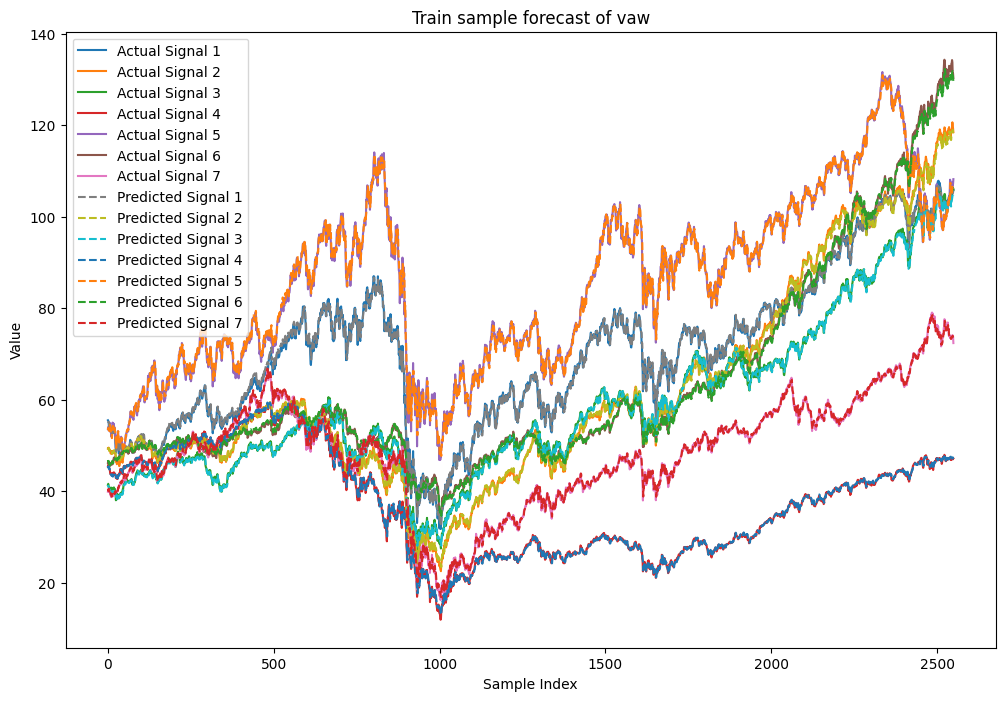

In [236]:

# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_train.squeeze()
Y_predicted = Y_predicted_train
plot_results(Y_squeezed, Y_predicted, 'Train sample forecast of vaw', random_color = True)

Y_predicted shape: (631, 7)
Y shape after squeezing: (631, 7)


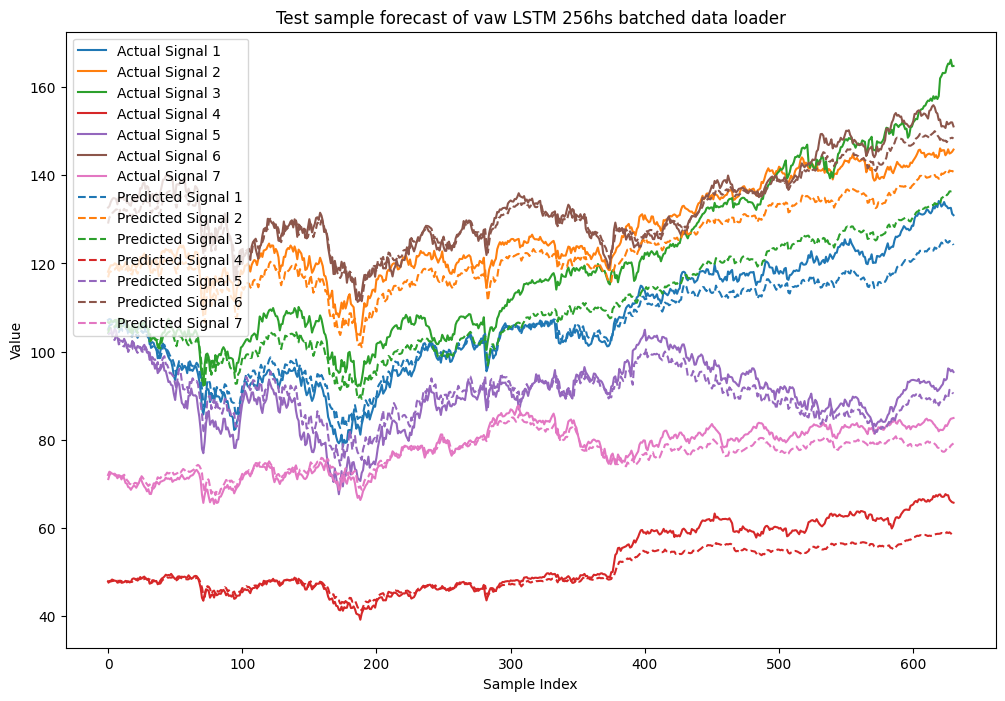

In [235]:
# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_test.squeeze()
Y_predicted = Y_predicted_test
plot_results(Y_squeezed, Y_predicted, 'Test sample forecast of vaw LSTM 256hs batched data loader')

Y_predicted shape: (60, 7)
Y shape after squeezing: (60, 7)


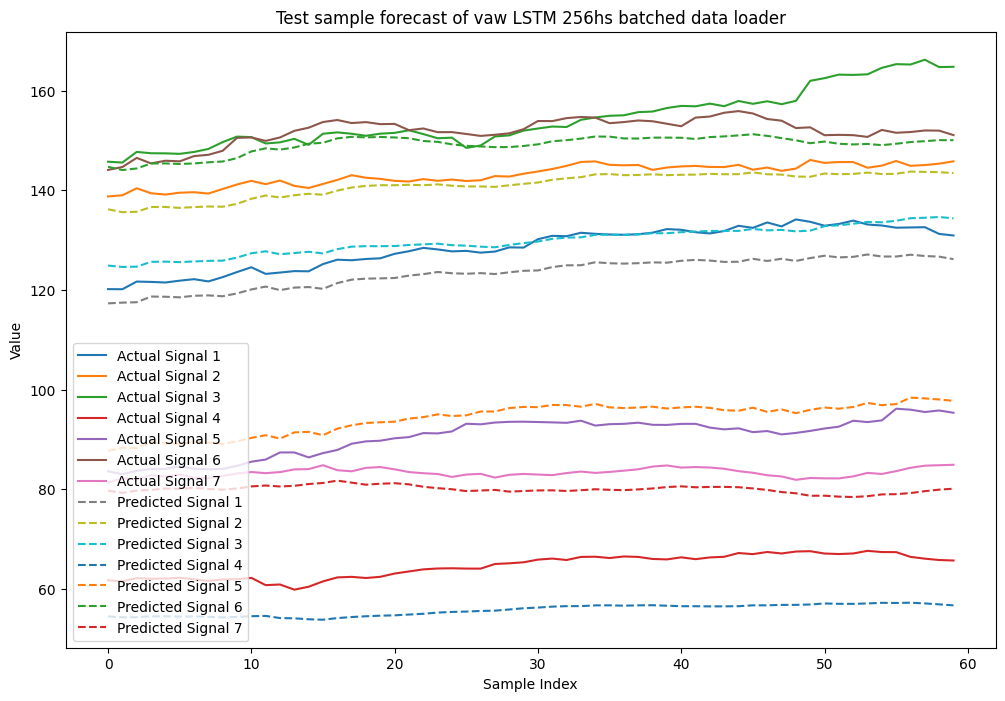

In [220]:
# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_test[-60:].squeeze()
Y_predicted = Y_predicted_test[-60:]
plot_results(Y_squeezed, Y_predicted, 'Test sample forecast of vaw LSTM 256hs batched data loader')

[[106.38622977 118.67476432 105.25681691 ... 104.59470819 130.7774986
   71.71181691]
 [107.40405293 119.66572114 106.37760934 ... 105.13444169 132.0002663
   72.6133507 ]
 [107.57380955 120.05443078 106.65337452 ... 104.95809267 132.60213858
   73.20448198]
 ...
 [126.82910496 143.7115926  134.50819096 ...  98.25099855 149.87957625
   79.63450765]
 [126.70008269 143.65303069 134.65397382 ...  98.0364118  150.08061691
   79.9441576 ]
 [126.19703228 143.46551593 134.38811531 ...  97.76179062 150.07108932
   80.12511145]]


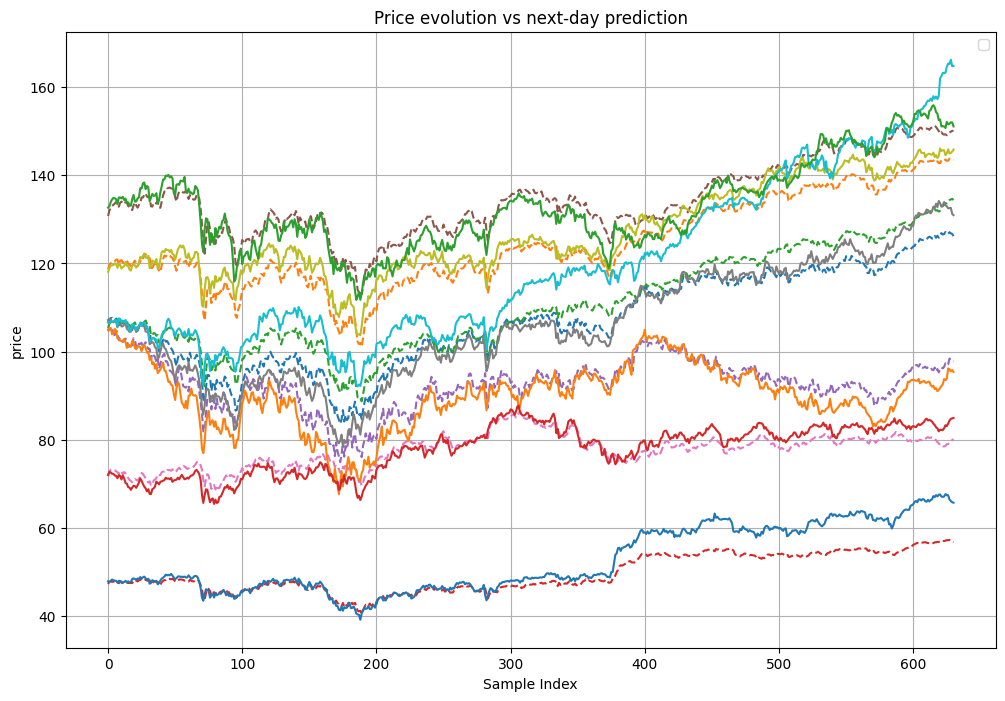

In [221]:
Y_predicted = model(X_test_pt).cpu().detach().numpy() * STD.T + MEAN.T
Y = Y_test_pt.cpu().detach().numpy() * STD.T + MEAN.T
print(Y_predicted)

plt.figure(figsize=(12, 8))
plt.plot(Y_predicted,linestyle='--',)
plt.plot(Y)
plt.title('Price evolution vs next-day prediction')
plt.xlabel('Sample Index')
plt.ylabel('price')
plt.legend()
plt.grid(True)
plt.show()